In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)


import click
import json
import time
import os
import itertools
import collections.abc

import matplotlib.pyplot as plt
import pandas as pd
import pennylane as qml
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
# from qiskit_ibm_provider import IBMProvider

from quantum.Evaluate import evaluate
from settings import ANSATZ_LIST, ENCODER_LIST
from quantum.Quantum import QuantumRegressor

from tqdm import tqdm

os.environ["OMP_NUM_THREADS"] = "12"

In [2]:
settings="./A2_HWE-CNOT/A2_HWE-CNOT.json"
train_set="./PCA5_0.8_Morgan_train.bin"
test_set="./PCA5_0.8_Morgan_test.bin"
scaler="./PCA5_0.8_Morgan_scaler.bin"

In [3]:
with open(train_set,'rb') as f:
    TRAIN = joblib.load(f)

with open(test_set,'rb') as f:
    TEST = joblib.load(f)

with open(scaler,'rb') as f:
    SCALER = joblib.load(f)



In [4]:
X_train, X_test, y_train, y_test = TRAIN['X'],TEST['X'],TRAIN['y'],TEST['y']

In [5]:
# 4. Define custom Dataset
class RegressionDataset(Dataset):
    def __init__(self, features, targets):
        self.X = torch.from_numpy(features).float()
        self.y = torch.from_numpy(targets).float()
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 5. Create DataLoaders
batch_size = 32
train_dataset = RegressionDataset(X_train, y_train)
test_dataset = RegressionDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [6]:
# Global variables
OPTIMIZER = None
SHOTS = None
X_DIM = None
BACKEND = None
DEVICE = None
SCALE_FACTORS = None
ANSATZ = None
ENCODER = None
POSTPROCESS = None
ERROR_MITIGATION = None
LAYERS = None
TOKEN = None
HYPERPARAMETERS = None
RE_UPLOAD_DEPTH = None
MAX_ITER = None
TOLERANCE = None
NUM_QUBITS = None
BATCH_SIZE = None
NUM_CORES = None
############################################
# Utility functions
############################################


def parse_settings(settings_file):
    with open(settings_file, 'r') as fp:
        settings = json.load(fp)

    global OPTIMIZER
    OPTIMIZER = settings['OPTIMIZER']

    global SHOTS
    SHOTS = settings['SHOTS']
                
    global BACKEND
    BACKEND = settings['BACKEND']

    global DEVICE
    DEVICE = settings['DEVICE']

    global SCALE_FACTORS
    SCALE_FACTORS = settings['SCALE_FACTORS']

    global POSTPROCESS
    POSTPROCESS = settings['POSTPROCESS']

    global ERROR_MITIGATION
    ERROR_MITIGATION = settings['ERROR_MITIGATION']

    global LAYERS
    LAYERS = settings['LAYERS']

    global HYPERPARAMETERS
    HYPERPARAMETERS = settings['HYPERPARAMETERS']
    # f was removed from HYPERPARAMETERS, this ensures old settings files can still run.
    if 'f' in HYPERPARAMETERS.keys():
        _ = HYPERPARAMETERS.pop('f', None)

    global RE_UPLOAD_DEPTH
    RE_UPLOAD_DEPTH = settings['RE-UPLOAD_DEPTH']

    global MAX_ITER
    MAX_ITER = settings['MAX_ITER']

    global TOLERANCE
    try:
        TOLERANCE = settings['TOLERANCE']
    except KeyError:
        TOLERANCE = None

    global NUM_QUBITS
    try:
        NUM_QUBITS = settings['NUM_QUBITS']
    except KeyError:
        NUM_QUBITS = None

    # classes aren't JSON serializable, so we store the key in the settings file and access it here.
    global ANSATZ
    ANSATZ = ANSATZ_LIST[settings['ANSATZ']]

    global ENCODER
    ENCODER = ENCODER_LIST[settings['ENCODER']]

    global BATCH_SIZE
    BATCH_SIZE = settings['BATCH_SIZE']
    
    global NUM_CORES
    NUM_CORES = settings['NUM_CORES']


In [7]:
def load_dataset(file):
    print(f'Loading dataset from {file}... ')
    data = joblib.load(file)
    X = data['X']
    y = data['y']

    global X_DIM
    _, X_DIM = X.shape
    print(f'Successfully loaded {file} into X and y data. ')
    return X, y

In [8]:

def create_kwargs():
    #  First have to apply specific ansatz settings: setting number of layers and the number of wires based on features
    ANSATZ.layers = LAYERS
    ANSATZ.set_wires(range(X_DIM))

    kwargs = {
        'encoder': ENCODER,
        'variational': ANSATZ,
        'num_qubits': X_DIM,
        'optimizer': OPTIMIZER,
        # 'optimizer': "BFGS",
        'max_iterations': MAX_ITER,
        'tol': TOLERANCE,
        'device': DEVICE,
        'shots': SHOTS,
        'backend': BACKEND,
        'postprocess': POSTPROCESS,
        'error_mitigation': ERROR_MITIGATION,
        'token': TOKEN,
        're_upload_depth': RE_UPLOAD_DEPTH,
        'batch_size': BATCH_SIZE,
        'njobs':NUM_CORES
    }
    return kwargs

In [9]:
X_train, y_train = load_dataset(train_set)
parse_settings(settings)
if DEVICE == 'qiskit.ibmq':
    save_token(instance, token)

global NUM_QUBITS
global X_DIM
if NUM_QUBITS is not None:
    X_DIM = NUM_QUBITS
elif X_DIM == 1:  # if X_DIM is None and num_qubits wasn't specified anywhere use a default value of 2.
    NUM_QUBITS = 2
    X_DIM = NUM_QUBITS

kwargs = create_kwargs()
title=False
if title is None:
    title = os.path.basename(settings)
    title, _ = os.path.splitext(title)



if test_set is not None:
    X_test, y_test = load_dataset(test_set)
else:
    X_test, y_test = None, None

scaler = joblib.load(scaler)

Loading dataset from ./PCA5_0.8_Morgan_train.bin... 
Successfully loaded ./PCA5_0.8_Morgan_train.bin into X and y data. 
Loading dataset from ./PCA5_0.8_Morgan_test.bin... 
Successfully loaded ./PCA5_0.8_Morgan_test.bin into X and y data. 


In [10]:
# 6. Define the model
class SimpleRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SimpleRegressor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.net(x)

# input_dim = X_train.shape[1]
# print(input_dim)
# hidden_dim = 64
# model = SimpleRegressor(input_dim, hidden_dim)



In [11]:
# # for i in range(1,5):
# device='qulacs.simulator'
# num_qubits=5
# device = qml.device(device, wires=num_qubits, expansion_strategy="device")


# re_upload_depth=3
# n_layers=1
# @qml.qnode(device, interface="torch")
# def circuit(inputs, weights):
#     print(inputs.shape,weights.shape)
#     for i in range(re_upload_depth):
#         qml.AngleEmbedding(inputs, wires=range(num_qubits))
#         qml.BasicEntanglerLayers(weights, wires=range(num_qubits))
    
#     return qml.expval(qml.PauliZ(0))




# # qml.draw_mpl(circuit,level=3)(train_dataset[0:][0],np.random.rand(n_layers,num_qubits))
# # # plt.savefig('trash.png')
# # plt.title(f"{n_layers} {np.random.rand(n_layers,num_qubits).shape}")
# # plt.show()



# weight_shapes = {"weights": (n_layers, num_qubits)}
# print(weight_shapes)
# qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = torch.nn.Sequential(*[qlayer]).to(device)
# print(model)
# print(model(train_dataset[0:][0]).shape)

In [12]:
num_qubits=5
re_upload_depth=3
# re_upload_depth=1
LAYERS=1

device='qulacs.simulator'
device = qml.device(device, wires=num_qubits, expansion_strategy="device")

encoder=ENCODER_LIST['A2']

variational=ANSATZ_LIST['HWE-CNOT']
variational.set_wires(range(num_qubits))
variational.layers = LAYERS


num_params = variational.num_params * re_upload_depth
generator = np.random.default_rng(12958234)
initial_parameters = generator.uniform(-np.pi, np.pi, num_params)
# @qml.qnode(device, interface="torch")
@qml.qnode(device, interface="torch")
def circuit(inputs, weights):
    #  builds the circuit with the given encoder and variational circuits.
    #  encoder and variational circuits must have only two required parameters, params/feats and wires
    weights = weights.reshape(re_upload_depth,-1)
    for i in range(re_upload_depth):
        params = weights[i]
        encoder(inputs, wires=range(num_qubits))
        variational(params, wires=range(num_qubits))        
    return qml.expval(qml.PauliZ(0))


In [23]:
weight_shapes = {"weights": (LAYERS,initial_parameters.size)}
print(weight_shapes)
# qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class HybridModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)

    def forward(self, x):
        print(x.shape)
        return self.qlayer(x)

model = HybridModel()


# model = torch.nn.Sequential(*[qlayer]).to(device)


{'weights': (1, 45)}


In [29]:
train_loader.dataset[0:][0]

tensor([[-0.5941, -0.1431, -0.1758, -0.4066, -0.1406],
        [ 0.3163, -0.4232, -0.0539, -0.2802,  0.4073],
        [-0.0969,  0.1750,  0.2447, -0.4534,  0.7159],
        ...,
        [-0.5789, -0.1309, -0.1567, -0.4055, -0.1173],
        [-0.2673, -0.2276,  0.9158, -0.1985,  0.8756],
        [-0.2988, -0.0245,  0.0329, -0.4425,  0.1181]])

In [30]:
model(train_loader.dataset[0:][0])

torch.Size([3509, 5])


ValueError: Cannot encode more features than there are wires

In [20]:
len(train_loader.dataset)

3509

In [22]:
# 7. Define loss and optimizer
criterion = nn.MSELoss()
learning_rate = 0.001
optimizer = optim.Adam(qlayer.parameters(), lr=learning_rate)

# 8. Training loop
epochs = 10
train_losses = []
test_losses = []

for epoch in tqdm(range(epochs)):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_X.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Evaluation on test set
    model.eval()
    test_running_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            test_running_loss += loss.item() * batch_X.size(0)
    test_epoch_loss = test_running_loss / len(test_loader.dataset)
    test_losses.append(test_epoch_loss)
    
    if (epoch+1) % 1 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {epoch_loss:.4e} - Test Loss: {test_epoch_loss:.4e} - {abs(epoch_loss-test_epoch_loss):.4e}")

    if epoch>0 and abs(epoch_loss-test_epoch_loss)<=1e-6 and abs(np.mean(train_losses[-3:])-np.mean(test_losses[-3:]))<=1e-6:
        print("Early stopping!")
        break

  0%|                                                                                                                                                                                                                  | 0/10 [00:00<?, ?it/s]


ValueError: Cannot encode more features than there are wires


Test MSE: 0.1208
Test MAE: 0.2708
Test R$^2$: -0.1253


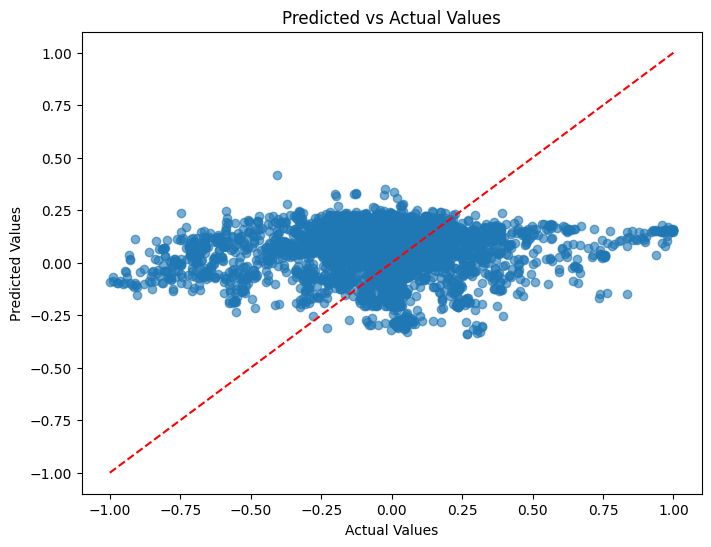

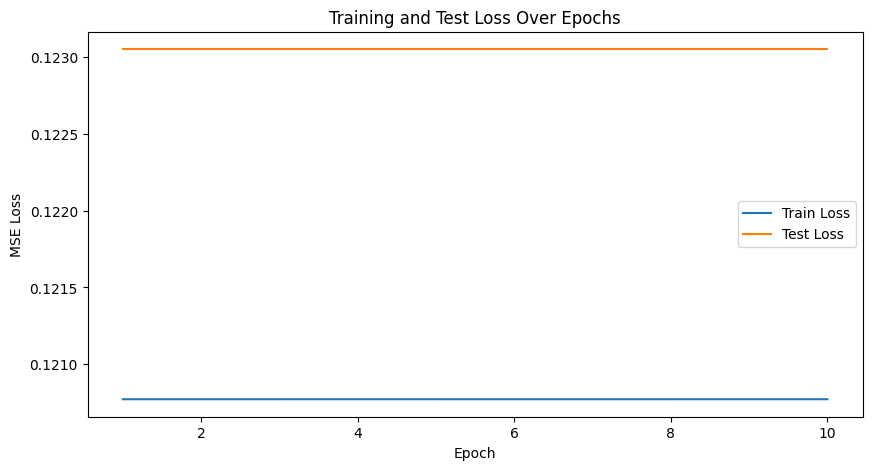

In [17]:
# 9. Evaluation
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch_X, batch_y in train_loader:
        outputs = torch.tensor([model(x) for x in batch_X])
        predictions.extend(outputs.squeeze().tolist())
        actuals.extend(batch_y.squeeze().tolist())

mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
print(f"\nTest MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R$^2$: {r2:.4f}")

# 10. Visualization
plt.figure(figsize=(8,6))
plt.scatter(actuals, predictions, alpha=0.6)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()

# 11. Plot Loss Curves
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

